# Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import numpy as np
from tensorflow.keras import layers
import time

# Dataset

In [2]:
(train_images,train_labels),(_,_)=tf.keras.datasets.fashion_mnist.load_data()

In [3]:
# checking the shape of our images
train_images.shape

(60000, 28, 28)

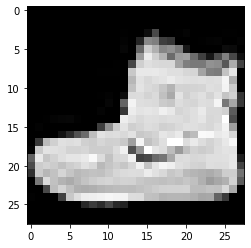

In [4]:
# looking at one image
plt.imshow(train_images[0,:,:],cmap='gray')

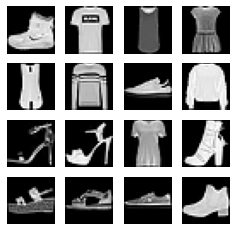

In [5]:
fig = plt.figure(figsize=(4,4))

for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(train_images[i, :, :], cmap='gray')
  plt.axis('off')

In [6]:
#reshaping 
train_images=train_images.reshape(60000,28,28,1).astype(np.float32)
# change the range of pixel values (between -1 to 1)
train_images=(train_images-127.5)/127.5

In [7]:
# creating the dataset
BATCH_SIZE=32
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(BATCH_SIZE)

# Generator

In [8]:
# generator from DCGAN architecture
def gen_model():

  model=tf.keras.Sequential()
  
  model.add(layers.Dense(7*7*256,use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Reshape((7,7,256)))

  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),use_bias=False,padding='same'))
  assert model.output_shape== (None,7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
  assert model.output_shape==(None,14,14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))
  assert model.output_shape==(None,28,28,1)

  return model

In [9]:
generator=gen_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

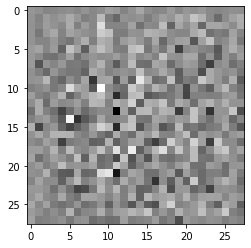

In [10]:
# trying our generator which is still not trained
noise=tf.random.normal([1,100])
generated_images=generator(noise,training=False)
plt.imshow(generated_images[0,:,:,0],cmap='gray')

# Discriminator

In [11]:
def disc_model():
  model=tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1,activation='sigmoid'))

  return model



In [12]:
discriminator=disc_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [13]:
# let's classify one image generated by our generator
predictions=discriminator(generated_images)
print(predictions)

tf.Tensor([[0.500002]], shape=(1, 1), dtype=float32)


# GAN

In [14]:
gan=tf.keras.models.Sequential([generator,discriminator])

# Compile the model

In [15]:
optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer)
discriminator.trainable=False
gan.compile(loss='binary_crossentropy',optimizer=optimizer)

# Training the GAN

In [16]:
def train_gan(gan,dataset,batch_size,n_epochs=50):
  generator,discriminator=gan.layers

  for epoch in range(n_epochs):
    start = time.time()

    for X_batch in dataset:

      # training the discriminator
      noise= tf.random.normal([batch_size,100])
      generated_images=generator(noise)
      fake_real_images=tf.concat([generated_images,X_batch],axis=0)
      y_disc=tf.constant([[0.]]*batch_size+[[1.]]*batch_size)
      discriminator.trainable=True
      discriminator.train_on_batch(fake_real_images,y_disc)

      # training the generator
      noise=tf.random.normal([batch_size,100])
      y_gen=tf.constant([[1.]]*batch_size)
      discriminator.trainable=False
      gan.train_on_batch(noise,y_gen)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

train_gan(gan,train_dataset,BATCH_SIZE)



Time for epoch 1 is 42.48895835876465 sec
Time for epoch 2 is 42.686017990112305 sec
Time for epoch 3 is 41.50907349586487 sec
Time for epoch 4 is 41.33460259437561 sec
Time for epoch 5 is 41.47722887992859 sec
Time for epoch 6 is 41.33400058746338 sec
Time for epoch 7 is 41.44485402107239 sec
Time for epoch 8 is 41.72430157661438 sec
Time for epoch 9 is 41.95275259017944 sec
Time for epoch 10 is 41.86096143722534 sec
Time for epoch 11 is 41.23469257354736 sec
Time for epoch 12 is 41.330700159072876 sec
Time for epoch 13 is 41.33072233200073 sec
Time for epoch 14 is 41.75166726112366 sec
Time for epoch 15 is 41.255460023880005 sec
Time for epoch 16 is 41.19942903518677 sec
Time for epoch 17 is 42.516357421875 sec
Time for epoch 18 is 42.38080167770386 sec
Time for epoch 19 is 44.46132707595825 sec
Time for epoch 20 is 43.55652213096619 sec
Time for epoch 21 is 42.51766324043274 sec
Time for epoch 22 is 42.771990060806274 sec
Time for epoch 23 is 42.77524948120117 sec
Time for epoch 24 

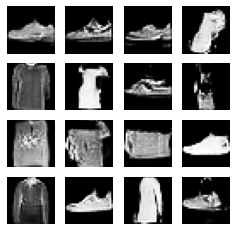

In [17]:
# showing some images
seed=tf.random.normal([16,100])
generated_images = generator(seed, training=False)

fig = plt.figure(figsize=(4,4))

for i in range(generated_images.shape[0]):
  plt.subplot(4, 4, i+1)
  plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')

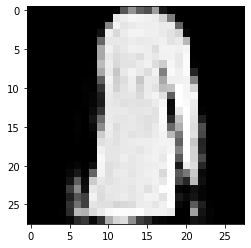

In [21]:
plt.imshow(generated_images[14, :, :, 0] * 127.5 + 127.5, cmap='gray')